In [1]:
import numpy as np
import scipy as sp
import KTCFwd
import KTCMeshing
import KTCRegularization
import KTCPlotting
import KTCScoring
import KTCAux
import matplotlib.pyplot as plt
import glob
import func
inputFolder = 'TrainingData'
outputFolder = 'Output'
categoryNbr = 1
Nel = 32
Con_Imp = 1e-6

In [2]:
fake = False
data_number = 1
mat_dict = sp.io.loadmat(inputFolder + '/ref.mat') #load the reference data
mat_files = glob.glob(inputFolder + '/data*.mat') # load the real data
mat_dict2 = sp.io.loadmat(mat_files[data_number-1])
Injref = mat_dict["Injref"] #current injections
Uelref = mat_dict["Uelref"] #measured voltages from water chamber
Inj = mat_dict2["Inj"]
Uel = mat_dict2["Uel"]

Mpat = mat_dict["Mpat"] #voltage measurement pattern
z = Con_Imp * np.ones((Nel, 1))  # contact impedances
Mesh, Mesh2, vincl, Mpat, Injref = func.SetupMesh(categoryNbr, Nel, inputFolder)



In [3]:
# Generate the fake noise free (but corrected) data
sigma0 = np.ones((len(Mesh.g), 1)) #linearization point
sigma0_init = sigma0

if fake:
    Path = 'GroundTruths/true' + str(data_number) + '.mat'
    solver = KTCFwd.EITFEM(Mesh2, Injref, Mpat, vincl)
    Uel = func.ForwardFromPhanton(Path, Mesh, Mesh2,Injref, Mpat, vincl,(0.8,0.6,1)) 
    Uelref = func.ForwardFromPhanton(Path, Mesh, Mesh2,Injref, Mpat, vincl,(0.8,0.8,0.8))

Begin the reconstruction

c:\Users\marti\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


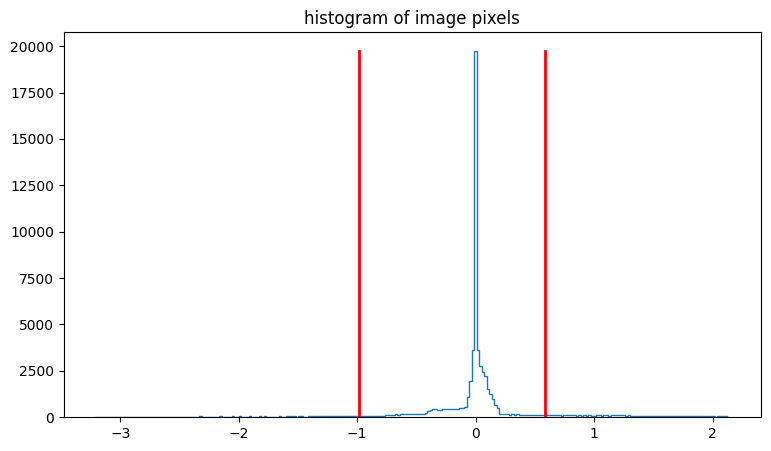

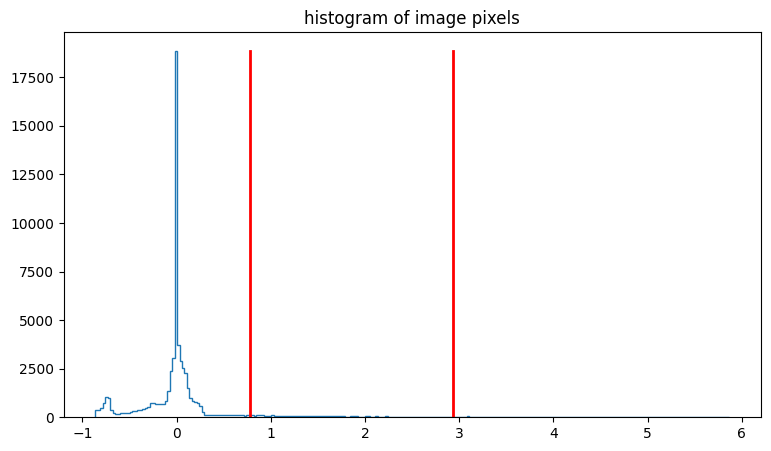

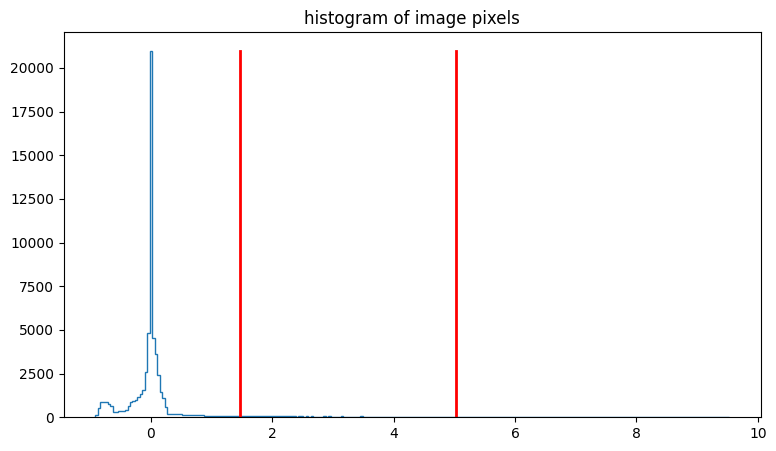

In [3]:
N_iter = 3
sigma0 = np.array(0.8*np.ones((len(Mesh.g), 1))) #linearization point
sigma0_init = sigma0
corrlength = 1 * 0.115 #used in the prior
var_sigma = 0.05 ** 2 #prior variance
mean_sigma = sigma0
smprior = KTCRegularization.SMPrior(Mesh.g, corrlength, var_sigma, mean_sigma)

# set up the forward solver for inversion
solver = KTCFwd.EITFEM(Mesh2, Injref, Mpat, vincl)

vincl = vincl.T.flatten()
# set up the noise model for inversion
noise_std1 = 0.05;  # standard deviation for first noise component (relative to each voltage measurement)
noise_std2 = 0.01;  # standard deviation for second noise component (relative to the largest voltage measurement)
solver.SetInvGamma(noise_std1, noise_std2, Uelref)

# Compute the difference of the measured real vs measured reference data
deltaU = Uel - Uelref
mask = np.array(vincl, bool) # Mask the removed electrodes
sigma0_special = sigma0
sigma0_temp = sigma0
for i in range(0,N_iter):
    sigma0 = sigma0_temp
    Usim = solver.SolveForward(sigma0, z) + (Uelref - solver.SolveForward(sigma0_init,z)) #forward solution at the linearization point with correction term
    deltaU = Uel - Usim
    J = solver.Jacobian(sigma0, z)
    deltareco = np.linalg.solve(J.T @ solver.InvGamma_n[np.ix_(mask,mask)] @ J + smprior.L.T @ smprior.L,J.T @ solver.InvGamma_n[np.ix_(mask,mask)] @ deltaU[vincl])
    sigma0_temp = np.array(sigma0 + deltareco)
    sigma0_special, reconstruction = func.applyOtsu(sigma0_temp, Mesh,sigmavalues = (0.8,0.4,1.4))

deltareco = sigma0_temp - sigma0_init

deltareco_pixgrid = KTCAux.interpolateRecoToPixGrid(deltareco, Mesh) # Interpolate to picture

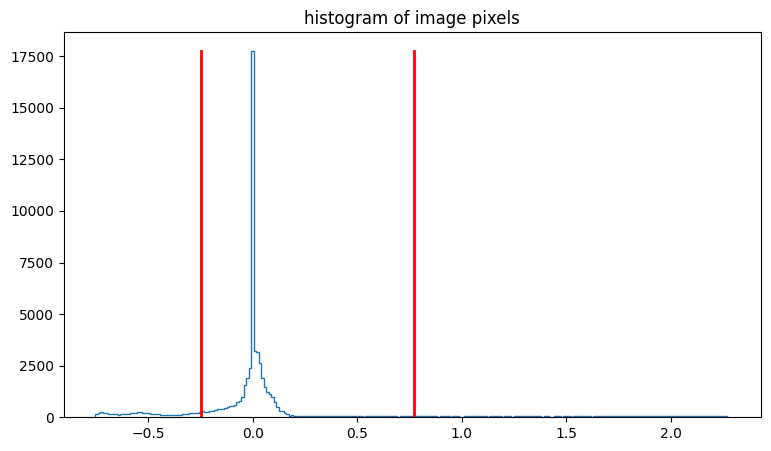

(-0.5, 255.5, 255.5, -0.5)

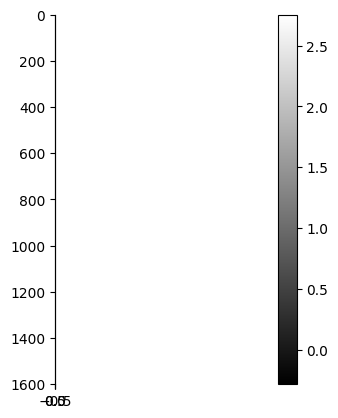

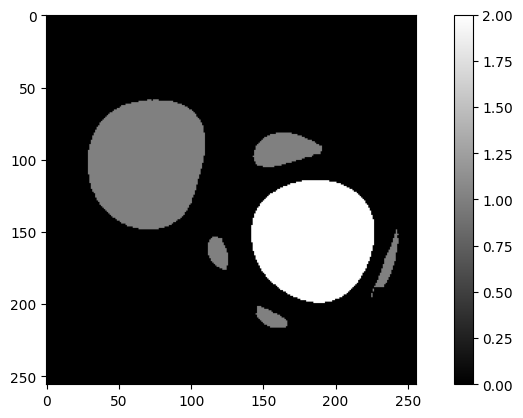

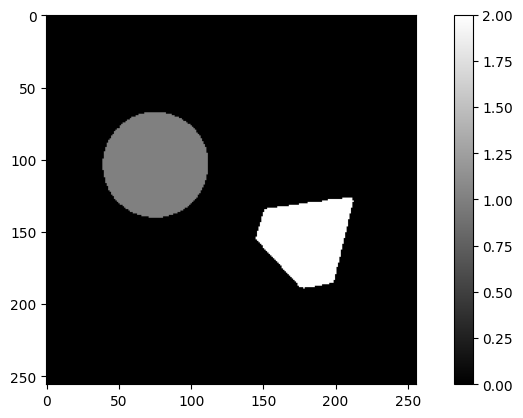

In [14]:
print(deltareco.shape)

(1602, 1)
